In [106]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels as sm
import statsmodels.api as api
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import curve_fit
from pmdarima.arima import auto_arima

# Loading the data, parsing the dates

In [107]:
df = pd.read_csv(r'C:\Users\motil\Desktop\TSA\project\Northern_Hemisphere_Monthly2.csv',index_col=0,parse_dates=True)

In [108]:
df

,Temperature
Time,
1880-01-01,-0.367828
1880-02-01,-0.479081
1880-03-01,-0.444028
1880-04-01,-0.374990
1880-05-01,-0.415901
...,...
2022-08-01,0.613061
2022-09-01,0.594641
2022-10-01,0.632713


# The series

<AxesSubplot:xlabel='Time'>

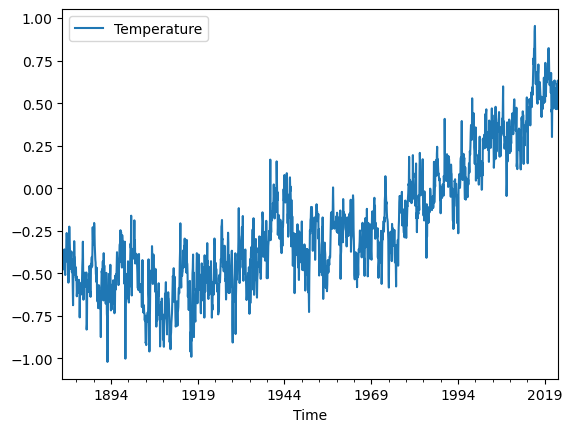

In [109]:
df.plot()

### Statistical description

In [110]:
df.describe()

,Temperature
count,1716.000000
mean,-0.226948
std,0.371417
min,-1.020839
25%,-0.506304
50%,-0.305353
75%,-0.001045
max,0.954100


In [111]:
X = df['Temperature']

### Lag plot

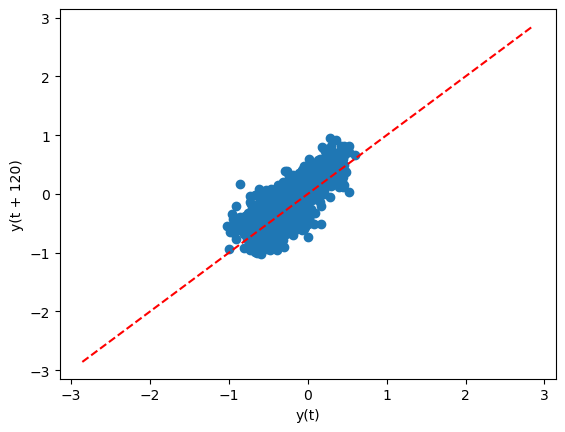

In [112]:
size = [i/300 for i in range(len(X))]
size = size-np.mean(size)
pd.plotting.lag_plot(df,lag=120)
plt.plot(size, size,'--', color='red')
plt.show()

# Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

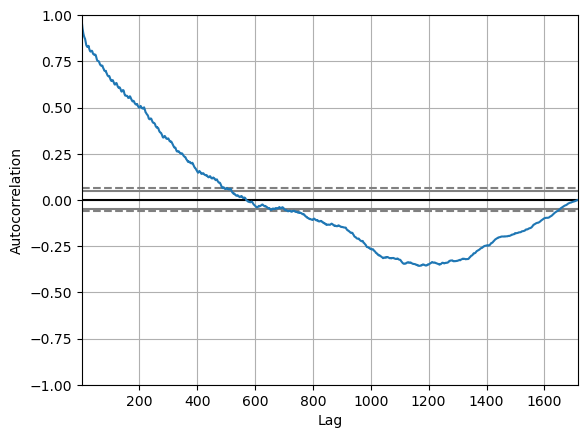

In [158]:
pd.plotting.autocorrelation_plot(df)

## Partial Autocorrelation

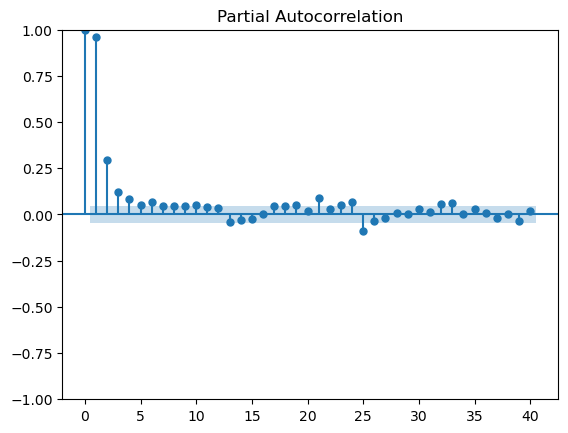

In [114]:
api.graphics.tsa.plot_pacf(df, lags=40,method='ywm')
plt.show()

# Augmented Dickey–Fuller

### H0: Not stationary , H1: Stationary

In [159]:
ad=adfuller(df)
print("ADF statistics: ",ad[0])
print("P-Value: ",ad[1])
print("Critical values:")
for key,value in ad[4].items():
    print(key,value)

ADF statistics:  -0.8171197310909852
P-Value:  0.8140414805402338
Critical values:
1% -3.434223006770802
5% -2.8632507142793737
10% -2.5676807398860144


### (found not stationary)

### Sliding the data

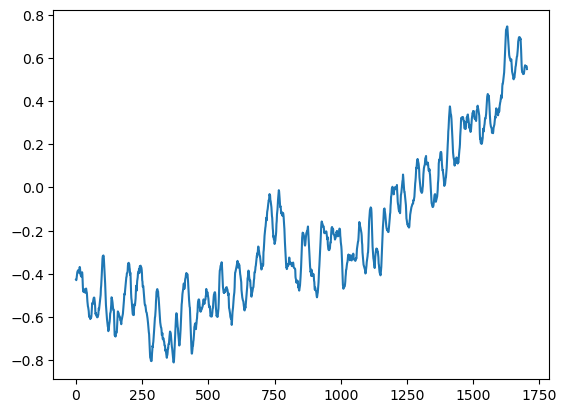

In [160]:
month_in_year=12
moving_average = [sum(X[i-6:i+month_in_year-6])/12 for i in range(6,len(X)-month_in_year+6)]
plt.plot(moving_average)
plt.show()

In [161]:
X = df[['Temperature']]

In [162]:
X

,Temperature
Time,
1880-01-01,-0.367828
1880-02-01,-0.479081
1880-03-01,-0.444028
1880-04-01,-0.374990
1880-05-01,-0.415901
...,...
2022-08-01,0.613061
2022-09-01,0.594641
2022-10-01,0.632713


# Preparing for regressions test

In [169]:
size = [i for i in range(len(X))]
size = np.reshape(size,(len(size),1))
Y = np.reshape(X ,(len(X),1))

In [170]:
poly_features = PolynomialFeatures(degree=2)
x_poly = poly_features.fit_transform(size)

In [171]:
lin_model = LinearRegression()
lin_model.fit(size,Y)

LinearRegression()

In [172]:
quard_model = LinearRegression()
quard_model.fit(x_poly,Y)

LinearRegression()

In [173]:
y_lin_pred = lin_model.predict(size)
y_quard_pred = quard_model.predict(x_poly)

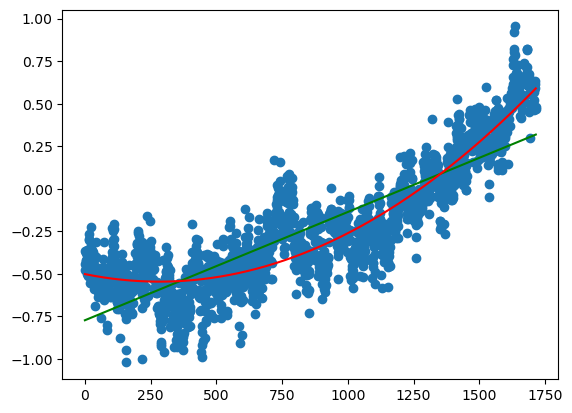

In [174]:
plt.scatter(size,Y)
plt.plot(size, y_lin_pred, color='green')
plt.plot(size, y_quard_pred, color='red')
plt.show()

In [175]:
lin_model.score(size,Y),quard_model.score(x_poly,Y)

(0.7209402676013454, 0.8281010021773145)

### (Quadratic model fits better)

In [176]:
coef = quard_model.coef_
intercept = quard_model.intercept_

# Print the polynomial equation
print(coef[0][2],"*x^2 " , coef[0][1],"*x" , intercept)

5.538031933191727e-07 *x^2  -0.000313330793779334 *x [-0.50137888]


# Filtering the trend

In [127]:
X = df['Temperature']
trend_filter = [X[i]-y_quard_pred[i] for i in range(len(X))]

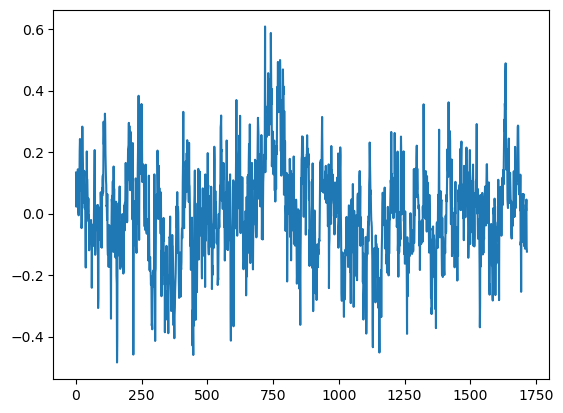

In [128]:
np_trend_filter = np.array(trend_filter).astype(float)
plt.plot(np_trend_filter)
plt.show()

In [129]:
df2=df.copy()
df2['after_trend']=np_trend_filter
df2

,Temperature,after_trend
Time,,
1880-01-01,-0.367828,0.133551
1880-02-01,-0.479081,0.022611
1880-03-01,-0.444028,0.057975
1880-04-01,-0.374990,0.127324
1880-05-01,-0.415901,0.086722
...,...,...
2022-08-01,0.613061,0.029278
2022-09-01,0.594641,0.009276
2022-10-01,0.632713,0.045765


# Filtering seasonality

In [130]:
result = seasonal_decompose(df2['after_trend'],model='additive',extrapolate_trend='freq')
result.seasonal

Time
1880-01-01   -0.010819
1880-02-01   -0.035410
1880-03-01   -0.030953
1880-04-01   -0.015534
1880-05-01   -0.012544
                ...   
2022-08-01    0.016004
2022-09-01    0.028950
2022-10-01    0.040044
2022-11-01    0.030077
2022-12-01   -0.017703
Name: seasonal, Length: 1716, dtype: float64

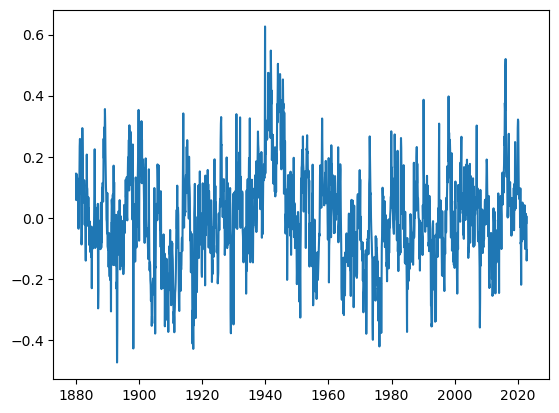

In [131]:
wn = df2['after_trend'] - result.seasonal
plt.plot(df.index,wn)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

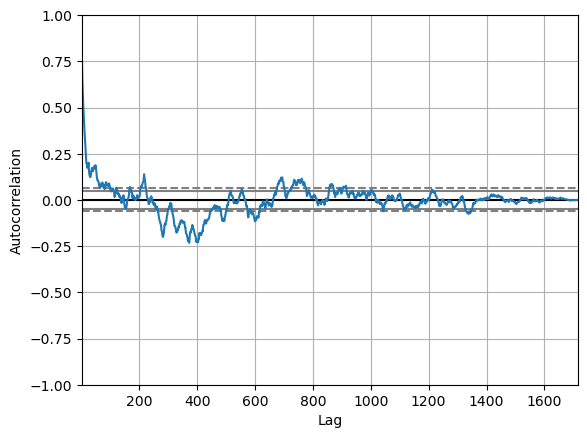

In [132]:
pd.plotting.autocorrelation_plot(wn)

### Autocorrelation function doesn't look like white noise

In [133]:
ad=adfuller(wn)
print("ADF statistics: ",ad[0])
print("P-Value: ",ad[1])
print("Critical values:")
for key,value in ad[4].items():
    print(key,value)

ADF statistics:  -8.641919022813415
P-Value:  5.397182406893948e-14
Critical values:
1% -3.434175427574795
5% -2.8632297119111967
10% -2.567669556525133


### WN test (Portmanteau)

In [134]:
def wn_portmanteau_hypothesis_auto(X,h):
    acf=api.tsa.acf(X,nlags=len(X)-1)
    Q=h*sum([i*i for i in acf[1:h+1]])
    if(Q>scipy.stats.chi2.ppf(0.95,h)):
        print("WN hypothesis rejected: Q=",Q," ppf_0.95=",scipy.stats.chi2.ppf(0.95,h))
    else:
        print("WN hypothesis accepted: Q=",Q," ppf_0.95=",scipy.stats.chi2.ppf(0.95,h))

In [135]:
wn_portmanteau_hypothesis_auto(wn,100)

WN hypothesis rejected: Q= 486.15567333942096  ppf_0.95= 124.34211340400407


### So found stationary, but not WN

In [136]:
X2=df2['after_trend']

### Trying to filter AR (Auto Regression) process

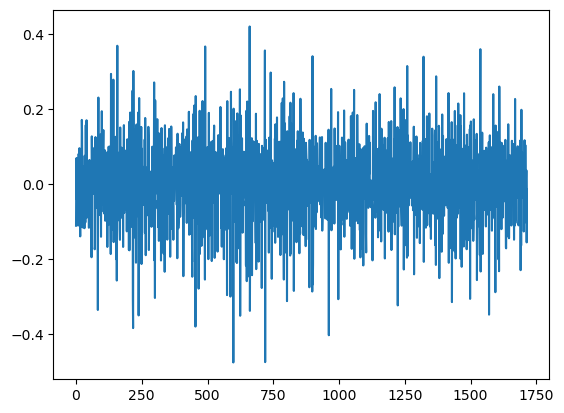

In [177]:
wn = [X2[i]-X2[i-1] for i in range(1,len(X2))]
plt.plot(wn)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

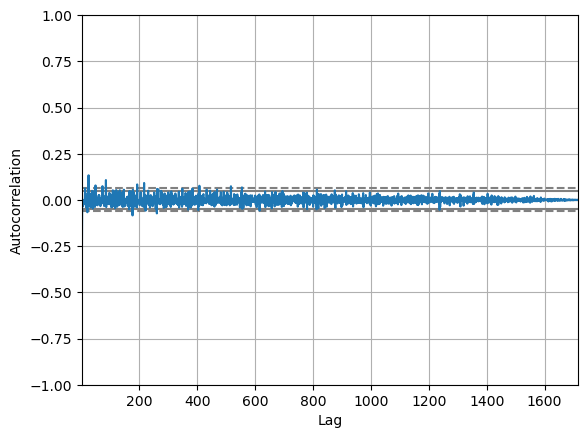

In [178]:
pd.plotting.autocorrelation_plot(wn)

In [139]:
wn_portmanteau_hypothesis_auto(wn,1000)

WN hypothesis accepted: Q= 644.0183901670524  ppf_0.95= 1074.679448803441


### Found white noise, all trends/seasonals/AR processes filterred

# Trying 2nd order differiating for quadratic trend

<AxesSubplot:xlabel='Time'>

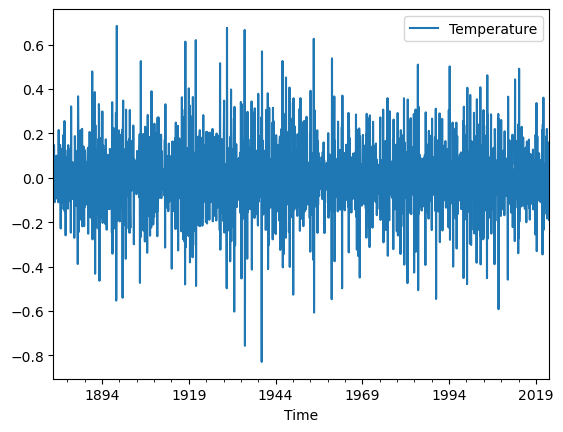

In [179]:
df.diff().diff().plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

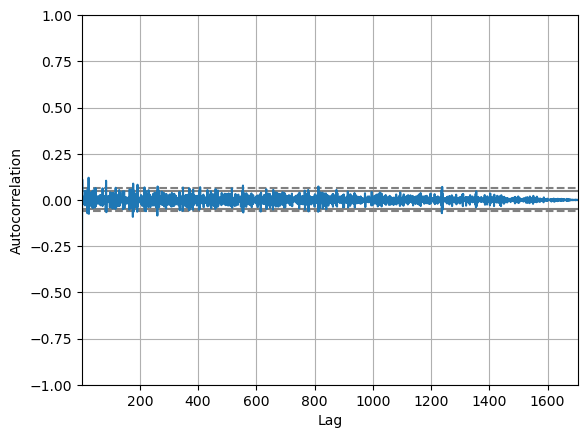

In [180]:
df2=df.diff().diff()
df2=df2['1881':'2022']
pd.plotting.autocorrelation_plot(df2)

In [142]:
wn_portmanteau_hypothesis_auto(df2,500)

WN hypothesis accepted: Q= 406.00611943339663  ppf_0.95= 553.1268089342569


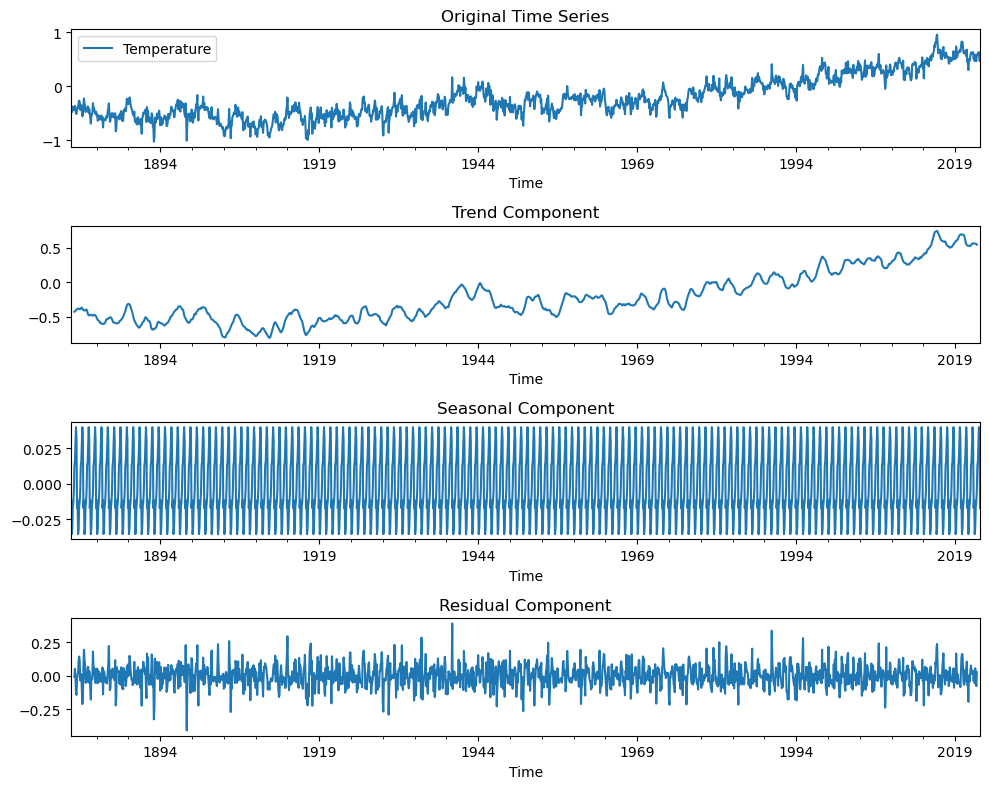

In [143]:
result = seasonal_decompose(df, model='additive', period=12)

# Plot the original time series and the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
df.plot(ax=ax1)
ax1.set_title('Original Time Series')
result.trend.plot(ax=ax2)
ax2.set_title('Trend Component')
result.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal Component')
result.resid.plot(ax=ax4)
ax4.set_title('Residual Component')
plt.tight_layout()
plt.show()

# Predictions

### Quatratic trend found

In [144]:
size = [i+1717 for i in range(len(X))]
size = np.reshape(size,(len(size),1))
poly_features = PolynomialFeatures(degree=2)
x_poly = poly_features.fit_transform(size)

In [145]:
y_pred_new = quard_model.predict(x_poly)
vari=np.var(X2)

In [146]:
forcast = [y_pred_new[i]+result.seasonal[i] for i in range(len(X))]

In [147]:
new_index = pd.date_range('2023-01-01', periods=1716, freq='M')
new_values = pd.DataFrame(forcast, index=new_index)
new_values['Temperature']=new_values[0]
# Concatenate the dataframes
new_df = pd.concat([df, new_values])
# Sort the index
new_df = new_df.sort_index()

<AxesSubplot:>

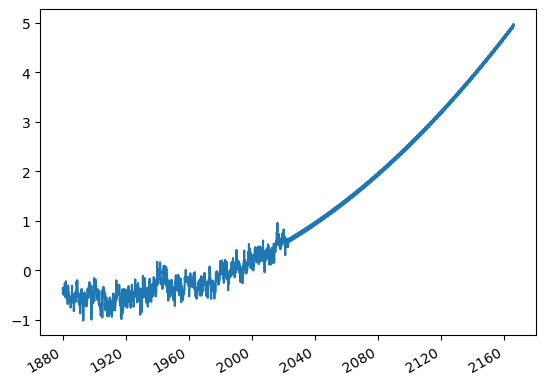

In [148]:
new_df['Temperature'].plot()

### 2nd order differentiating prediction

In [149]:
forcast2 = [X[1715],X[1714]]
for i in range(2,len(X)):
    forcast2.append(2*forcast2[i-1]-forcast2[i-2]+0.0000501)

In [150]:
new_index = pd.date_range('2023-01-01', periods=1716, freq='M')
new_values2 = pd.DataFrame(forcast2, index=new_index)
new_values2['Temperature']=new_values2[0]
# Concatenate the dataframes
new_df2 = pd.concat([df, new_values2])
# Sort the index
new_df2 = new_df2.sort_index()

<AxesSubplot:>

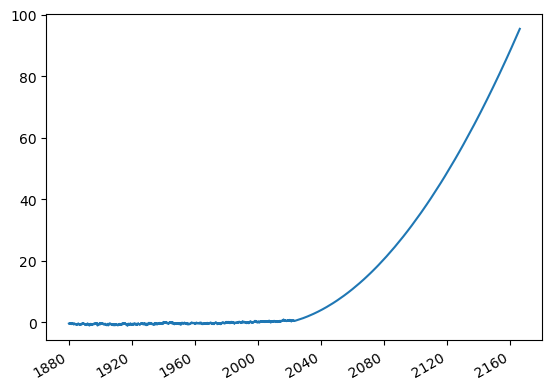

In [151]:
new_df2['Temperature'].plot()

### ARIMA

In [182]:
arima_mod = auto_arima(df,start_p=0,d=2,start_q=0,max_p=5,max_d=2,max_q=5,seasonal= False,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1200.656, Time=0.84 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1993.924, Time=0.47 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-1202.656, Time=0.39 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-2316.802, Time=1.63 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-2504.055, Time=1.14 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-2603.070, Time=1.28 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-2679.639, Time=5.25 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-3030.289, Time=6.84 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-3019.928, Time=5.88 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.61 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=-3030.240, Time=6.43 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=4.83 sec

Best model:  ARIMA(5,2,1)(0,0,0)[0] intercept
Total fit time: 45.416 seconds


In [183]:
arima_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1716
Model:               SARIMAX(5, 2, 1)   Log Likelihood                1523.145
Date:                Wed, 05 Jul 2023   AIC                          -3030.289
Time:                        19:14:32   BIC                          -2986.716
Sample:                    01-01-1880   HQIC                         -3014.165
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.455e-05      0.000      0.689      0.491      -0.000       0.000
ar.L1         -0.3619      0.022    -16.358      0.000      -0.405      -0.319
ar.L2         -0.1870      0.026     -7.179      0.000      -0.238      -0.136
ar.L3         -0.1356      0.028     -4.801      0.000      -0.191      -0.080
ar.L4         -0.1178      0.029     -4.049      0.000      -0.175      -0.061
ar.L5         -0.0404      0.029     -1.386      0.166      -0.098       0.017
ma.L1         -0.9552      0.015    -65.181      0.000      -0.984      -0.926
sigma2         0.0093      0.000     36.458      0.000       0.009       0.010
===================================================================================
Ljung-Box (L1) (Q):                   3.02   Jarque-Bera (JB):               132.94
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.32
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residuals modeling

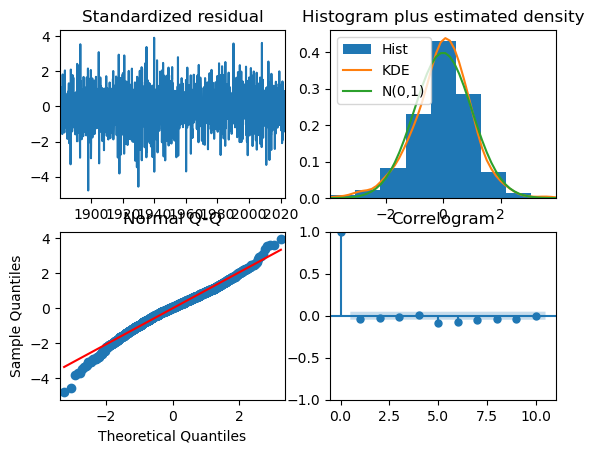

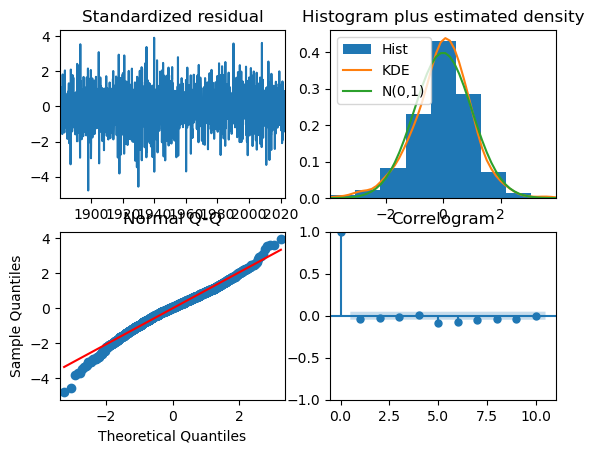

In [188]:
arima_mod.plot_diagnostics()

In [189]:
newar=np.array(arima_mod.predict(n_periods=1716))

In [190]:
new_index = pd.date_range('2023-01-01', periods=1716, freq='M')
new_values3 = pd.DataFrame(newar, index=new_index)
new_values3['Temperature']=new_values3[0]
# Concatenate the dataframes
new_df3 = pd.concat([df, new_values3])
# Sort the index
new_df3 = new_df3.sort_index()

<AxesSubplot:>

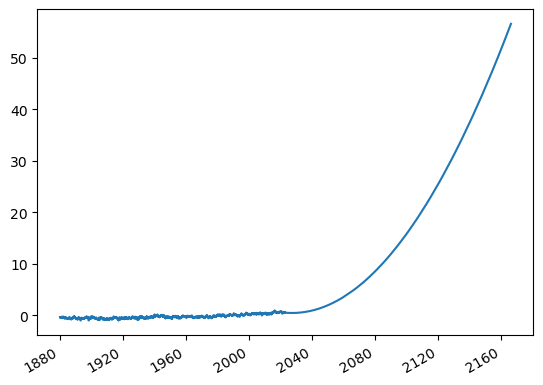

In [191]:
new_df3['Temperature'].plot()